In [2]:
import keras
from context import * # imports the MDN layer 
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
%matplotlib inline
import h5py
from keras.models import model_from_json
from keras.optimizers import Adam
from predictions import define_models, mdn_predict_sequence, predict_z
from midi_handling import switch_range, noteArrayToStream
from keras.utils import multi_gpu_model
from my_classes import MDNDataGenerator
from data_prep import one_hot_decode
from music21 import converter, instrument, note, chord, stream, midi, environment
# Only for GPU use:
#os.environ["CUDA_VISIBLE_DEVICES"]="1"


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

mdn_dataset_path = "h5_files/mdn_dataset_pre.h5"
vae_weights_path = "weights/512_64/weights-improvement-2455-1.00.hdf5"

############################ MDN initalisation ###################################
SEQ_LEN = 16
BATCH_SIZE = 64
HIDDEN_UNITS = 512
EPOCHS = 400
SEED = 2345  # set random seed for reproducibility


OUTPUT_DIMENSION = 64
NUMBER_MIXTURES = 10

random.seed(SEED)
np.random.seed(SEED)
############################ VAE initalisation ###################################
n_features = 131
timesteps = 16
learning_rate = 0.0001
n_encoder_units = 512
n_decoder_units = n_encoder_units
latent_dim = 64
dropout=0.3
beta=1
############################ MUSESCORE intialisation ###############################
environment.set("musescoreDirectPNGPath", "/usr/bin/musescore")

### Setup an MDN RNN

In [3]:
inputs = keras.layers.Input(shape=(SEQ_LEN,OUTPUT_DIMENSION), name='inputs')
lstm1_out = keras.layers.LSTM(HIDDEN_UNITS, name='lstm1', return_sequences=True)(inputs)
lstm2_out = keras.layers.LSTM(HIDDEN_UNITS, name='lstm2', return_sequences=True)(lstm1_out)
mdn_out = keras.layers.TimeDistributed(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES, name='mdn_outputs'), name='td_mdn')(lstm2_out)

model = keras.models.Model(inputs=inputs, outputs=mdn_out)
optimizer = Adam(clipnorm=1., lr=0.0001)
#model = multi_gpu_model(model, gpus=2)
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 16, 64)            0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 16, 512)           1181696   
_________________________________________________________________
lstm2 (LSTM)                 (None, 16, 512)           2099200   
_________________________________________________________________
td_mdn (TimeDistributed)     (None, 16, 1290)          661770    
Total params: 3,942,666
Trainable params: 3,942,666
Non-trainable params: 0
_________________________________________________________________


### Get generator info

In [4]:
num_training_samples = 10000
num_validation_samples = 1000
steps_per_epoch = int(num_training_samples / BATCH_SIZE)
validation_steps = int(num_validation_samples / BATCH_SIZE)

params = {'dim': (SEQ_LEN, OUTPUT_DIMENSION),
          'batch_size': BATCH_SIZE,
          'dataset_path': mdn_dataset_path, ### IMPORTANT
          'shuffle': True}

ID_list_dict = {}

# Datasets
ID_list = np.load("ID_lists/mdn_ID_list_pre.npy")

ID_list_dict["train"] = ID_list.item().get("train")
ID_list_dict["validation"] = ID_list.item().get("validation")

# Generators
training_generator = MDNDataGenerator(ID_list_dict['train'], **params)
validation_generator = MDNDataGenerator(ID_list_dict['validation'], **params)

In [7]:
# Train model on dataset
filepath="weights/MDN_pre-weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = keras.callbacks.TensorBoard(log_dir="tb_trained_models/mdnpre", batch_size=BATCH_SIZE)

history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    use_multiprocessing=False,
                    epochs=EPOCHS,verbose=2,callbacks=[keras.callbacks.TerminateOnNaN(),
                                                       checkpoint,
                                                       tensorboard])

Epoch 1/400
 - 8s - loss: 220.5272 - val_loss: 202.7098

Epoch 00001: val_loss improved from inf to 202.70976, saving model to weights/MDN_pre-weights-improvement-01-202.71.hdf5
Epoch 2/400
 - 8s - loss: 218.4642 - val_loss: 197.6292

Epoch 00002: val_loss improved from 202.70976 to 197.62919, saving model to weights/MDN_pre-weights-improvement-02-197.63.hdf5
Epoch 3/400
 - 8s - loss: 217.0276 - val_loss: 191.4881

Epoch 00003: val_loss improved from 197.62919 to 191.48811, saving model to weights/MDN_pre-weights-improvement-03-191.49.hdf5
Epoch 4/400
 - 8s - loss: 215.5447 - val_loss: 187.5852

Epoch 00004: val_loss improved from 191.48811 to 187.58519, saving model to weights/MDN_pre-weights-improvement-04-187.59.hdf5
Epoch 5/400
 - 8s - loss: 215.0865 - val_loss: 184.4206

Epoch 00005: val_loss improved from 187.58519 to 184.42064, saving model to weights/MDN_pre-weights-improvement-05-184.42.hdf5
Epoch 6/400
 - 8s - loss: 213.6780 - val_loss: 181.2980

Epoch 00006: val_loss improve

 - 8s - loss: 195.2474 - val_loss: 161.4961

Epoch 00064: val_loss did not improve from 156.29531
Epoch 65/400
 - 8s - loss: 195.3830 - val_loss: 159.0438

Epoch 00065: val_loss did not improve from 156.29531
Epoch 66/400
 - 8s - loss: 195.0084 - val_loss: 162.2399

Epoch 00066: val_loss did not improve from 156.29531
Epoch 67/400
 - 8s - loss: 195.1723 - val_loss: 162.3675

Epoch 00067: val_loss did not improve from 156.29531
Epoch 68/400
 - 8s - loss: 194.7689 - val_loss: 159.4385

Epoch 00068: val_loss did not improve from 156.29531
Epoch 69/400
 - 8s - loss: 195.0159 - val_loss: 162.9695

Epoch 00069: val_loss did not improve from 156.29531
Epoch 70/400
 - 8s - loss: 194.9081 - val_loss: 157.4935

Epoch 00070: val_loss did not improve from 156.29531
Epoch 71/400
 - 8s - loss: 194.9674 - val_loss: 161.1680

Epoch 00071: val_loss did not improve from 156.29531
Epoch 72/400
 - 8s - loss: 194.3282 - val_loss: 157.2329

Epoch 00072: val_loss did not improve from 156.29531
Epoch 73/400
 

 - 8s - loss: 191.0241 - val_loss: 158.5337

Epoch 00136: val_loss did not improve from 154.75139
Epoch 137/400
 - 8s - loss: 191.4994 - val_loss: 159.4754

Epoch 00137: val_loss did not improve from 154.75139
Epoch 138/400
 - 8s - loss: 190.2313 - val_loss: 159.1614

Epoch 00138: val_loss did not improve from 154.75139
Epoch 139/400
 - 8s - loss: 191.6687 - val_loss: 159.3177

Epoch 00139: val_loss did not improve from 154.75139
Epoch 140/400
 - 8s - loss: 191.5078 - val_loss: 158.9163

Epoch 00140: val_loss did not improve from 154.75139
Epoch 141/400
 - 8s - loss: 190.3764 - val_loss: 159.9976

Epoch 00141: val_loss did not improve from 154.75139
Epoch 142/400
 - 8s - loss: 191.3900 - val_loss: 161.4008

Epoch 00142: val_loss did not improve from 154.75139
Epoch 143/400
 - 8s - loss: 191.4091 - val_loss: 158.3738

Epoch 00143: val_loss did not improve from 154.75139
Epoch 144/400
 - 8s - loss: 191.1574 - val_loss: 159.4644

Epoch 00144: val_loss did not improve from 154.75139
Epoch 


Epoch 00209: val_loss did not improve from 154.75139
Epoch 210/400
 - 8s - loss: 189.8082 - val_loss: 159.1878

Epoch 00210: val_loss did not improve from 154.75139
Epoch 211/400
 - 8s - loss: 189.4155 - val_loss: 162.6682

Epoch 00211: val_loss did not improve from 154.75139
Epoch 212/400
 - 8s - loss: 189.4775 - val_loss: 159.3103

Epoch 00212: val_loss did not improve from 154.75139
Epoch 213/400
 - 8s - loss: 189.0731 - val_loss: 160.9563

Epoch 00213: val_loss did not improve from 154.75139
Epoch 214/400
 - 8s - loss: 189.6914 - val_loss: 161.4117

Epoch 00214: val_loss did not improve from 154.75139
Epoch 215/400
 - 8s - loss: 188.6561 - val_loss: 161.5024

Epoch 00215: val_loss did not improve from 154.75139
Epoch 216/400
 - 8s - loss: 189.6598 - val_loss: 155.5833

Epoch 00216: val_loss did not improve from 154.75139
Epoch 217/400
 - 8s - loss: 188.9019 - val_loss: 162.4335

Epoch 00217: val_loss did not improve from 154.75139
Epoch 218/400
 - 8s - loss: 189.3213 - val_loss: 1

 - 9s - loss: 187.8082 - val_loss: 160.4793

Epoch 00283: val_loss did not improve from 154.75139
Epoch 284/400
 - 9s - loss: 188.2001 - val_loss: 157.5987

Epoch 00284: val_loss did not improve from 154.75139
Epoch 285/400
 - 9s - loss: 188.0386 - val_loss: 163.0069

Epoch 00285: val_loss did not improve from 154.75139
Epoch 286/400
 - 9s - loss: 187.8965 - val_loss: 159.1442

Epoch 00286: val_loss did not improve from 154.75139
Epoch 287/400
 - 9s - loss: 187.5631 - val_loss: 159.8370

Epoch 00287: val_loss did not improve from 154.75139
Epoch 288/400
 - 9s - loss: 188.5951 - val_loss: 161.3595

Epoch 00288: val_loss did not improve from 154.75139
Epoch 289/400
 - 9s - loss: 187.9829 - val_loss: 163.2954

Epoch 00289: val_loss did not improve from 154.75139
Epoch 290/400
 - 9s - loss: 187.7689 - val_loss: 161.3183

Epoch 00290: val_loss did not improve from 154.75139
Epoch 291/400
 - 9s - loss: 188.0054 - val_loss: 160.6739

Epoch 00291: val_loss did not improve from 154.75139
Epoch 


Epoch 00356: val_loss did not improve from 154.75139
Epoch 357/400
 - 8s - loss: 186.8887 - val_loss: 161.9359

Epoch 00357: val_loss did not improve from 154.75139
Epoch 358/400
 - 8s - loss: 186.8523 - val_loss: 158.8164

Epoch 00358: val_loss did not improve from 154.75139
Epoch 359/400
 - 8s - loss: 186.9637 - val_loss: 160.9624

Epoch 00359: val_loss did not improve from 154.75139
Epoch 360/400
 - 8s - loss: 186.8654 - val_loss: 164.3261

Epoch 00360: val_loss did not improve from 154.75139
Epoch 361/400
 - 8s - loss: 186.7517 - val_loss: 160.6198

Epoch 00361: val_loss did not improve from 154.75139
Epoch 362/400
 - 8s - loss: 187.1286 - val_loss: 160.1948

Epoch 00362: val_loss did not improve from 154.75139
Epoch 363/400
 - 8s - loss: 186.7327 - val_loss: 160.4705

Epoch 00363: val_loss did not improve from 154.75139
Epoch 364/400
 - 8s - loss: 186.9298 - val_loss: 161.4710

Epoch 00364: val_loss did not improve from 154.75139
Epoch 365/400
 - 8s - loss: 186.8330 - val_loss: 1

### Decoder model

In [8]:
# Decoding Model
# Same as training model except for dimension and mixtures.

decoder = keras.Sequential()
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(1,1,OUTPUT_DIMENSION), return_sequences=True, stateful=True))
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, stateful=True))
decoder.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))
decoder.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=keras.optimizers.Adam())
decoder.summary()


decoder.load_weights("weights/MDN_pre-weights-improvement-86-155.28.hdf5")
print("Loaded MDN weights from disk")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 1, 512)               1181696   
_________________________________________________________________
lstm_2 (LSTM)                (1, 512)                  2099200   
_________________________________________________________________
mdn_1 (MDN)                  (1, 1290)                 661770    
Total params: 3,942,666
Trainable params: 3,942,666
Non-trainable params: 0
_________________________________________________________________
Loaded MDN weights from disk


## Get MusicVAE

In [9]:
# define model
train, infenc, infdec = define_models(n_encoder_units=n_encoder_units,
                                        n_decoder_units=n_decoder_units,
                                        latent_dim=latent_dim, 
                                      timesteps=timesteps,
                                      n_features=n_features,
                                      learning_rate=learning_rate,
                                        dropout=dropout,
                                      beta=beta,
                                        epsilon_std=1.)

train.load_weights(vae_weights_path)
print("Loaded VAE weights from disk")

all_weights = train.get_weights()
decoder_position = len(infenc.get_weights())
decoder_weights = all_weights[decoder_position::]
encoder_weights = all_weights[:decoder_position]

infenc.set_weights(encoder_weights)
infdec.set_weights(decoder_weights)

Loaded VAE weights from disk


## Predict

In [12]:
test_ID_list_dict = []
ID_list = np.load("ID_lists/test_ID_list.npy")

test_list = ID_list.item().get("test_labels")

input_songs = []
output_songs = []

ID = test_list[14]
encoder_input = np.load('encoder_inputs/' + ID + '.npy').reshape(1, SEQ_LEN, n_features)    

z = predict_z(infenc=infenc,source=encoder_input,latent_dim=OUTPUT_DIMENSION)

mdn_song = []

for i in range(25):

    params = decoder.predict(z.reshape(1,1,64))
    z = mdn.sample_from_output(params[0], OUTPUT_DIMENSION, NUMBER_MIXTURES, temp=1.5)

    song = mdn_predict_sequence(infdec=infdec,
                                 z=z,
                                 latent_dim=OUTPUT_DIMENSION,
                                 seq_len=SEQ_LEN,
                                 temperature=1,
                                 n_decoder_units=n_decoder_units)
    
    mdn_song.append(one_hot_decode(song.reshape(SEQ_LEN, 131)))

In [13]:
mdn_song = np.ravel(mdn_song)

In [14]:
mdn_song = switch_range(mdn_song)

/home/viktoro/keras/venv/lib/python3.5/site-packages/music21/ipython21/objects.py:16: ResourceWarning: unclosed file <_io.BufferedReader name='/tmp/music21/tmperagkacn-1.png'>
  data = open(fp, 'rb').read()


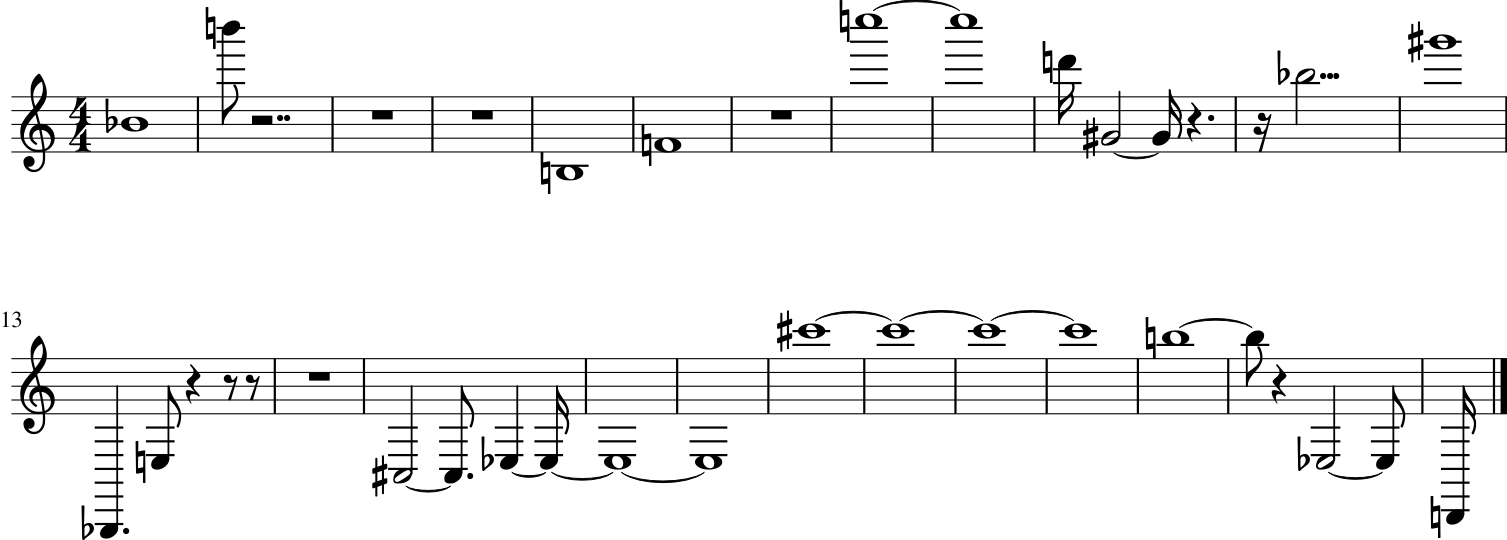

In [15]:
melody_stream = noteArrayToStream(switch_range(list(np.ravel(mdn_song))))

melody_stream.show()

In [16]:
mdn_song

array([129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,
       129, 129, 129,  70, 129, 129, 129, 129, 129, 129, 129, 129, 129,
       129, 129, 129, 129, 129, 129,  95, 129, 128, 129, 129, 129, 129,
       129, 129, 129, 129, 129, 129, 129, 129, 129, 128, 129, 129, 129,
       129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,
       129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,
       129, 129,  59, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,
       129, 129, 129, 129, 129,  65, 129, 129, 129, 129, 129, 129, 129,
       129, 129, 129, 129, 129, 129, 129, 129, 128, 129, 129, 129, 129,
       129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,  96, 129,
       129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,
       129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,
       129, 129, 129, 129,  86,  68, 129, 129, 129, 129, 129, 129, 129,
       129, 128, 129, 129, 129, 129, 129, 129,  82, 129, 129, 12